# Heart Disease Detection - ML Pipeline
## Step 1: Import Libraries & Setup

In [ ]:
# Core Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# sklearn - Models & CV
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Optuna for hyperparameter optimization
import optuna
from optuna.pruners import MedianPruner

# Utilities
import subprocess
import sys
import time
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Step 2: Load Data

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


## Step 3: Data Exploration

In [4]:
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (630000, 15)
Test data shape: (270000, 14)


In [5]:
print("Missing Training data:", train_df.isna().sum().sum())
print("Missing Test data:", test_df.isna().sum().sum())

Missing Training data: 0
Missing Test data: 0


In [6]:
print("Training data info:")
train_df.info()

Training data info:


<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Heart Disease  

In [7]:
print("Training data description:")
train_df.describe()

Training data description:


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873
std,181865.479132,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007
min,0.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,157499.750000,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,314999.500000,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,472499.250000,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,629999.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


## Step 4: Feature Definition & Target Encoding

In [8]:
target = "Heart Disease"

numcols = [
    "Age", "BP", "Cholesterol", "Max HR", "ST depression"
]

catcols = [
    "Sex", "Chest pain type", "FBS over 120", "EKG results",
    "Exercise angina", "Slope of ST",
    "Number of vessels fluro", "Thallium"
]

drop_cols = ["id"]

In [ ]:
X = train_df.drop(columns=[target] + drop_cols)
y = train_df[target]

# ENCODE TARGET VARIABLE 
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = pd.Series(y_encoded, index=y.index)

print(f"Target encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"Encoded target distribution:\n{y.value_counts().sort_index()}")

Target encoding: {'Absence': np.int64(0), 'Presence': np.int64(1)}
Encoded target distribution:
0    347546
1    282454
Name: count, dtype: int64


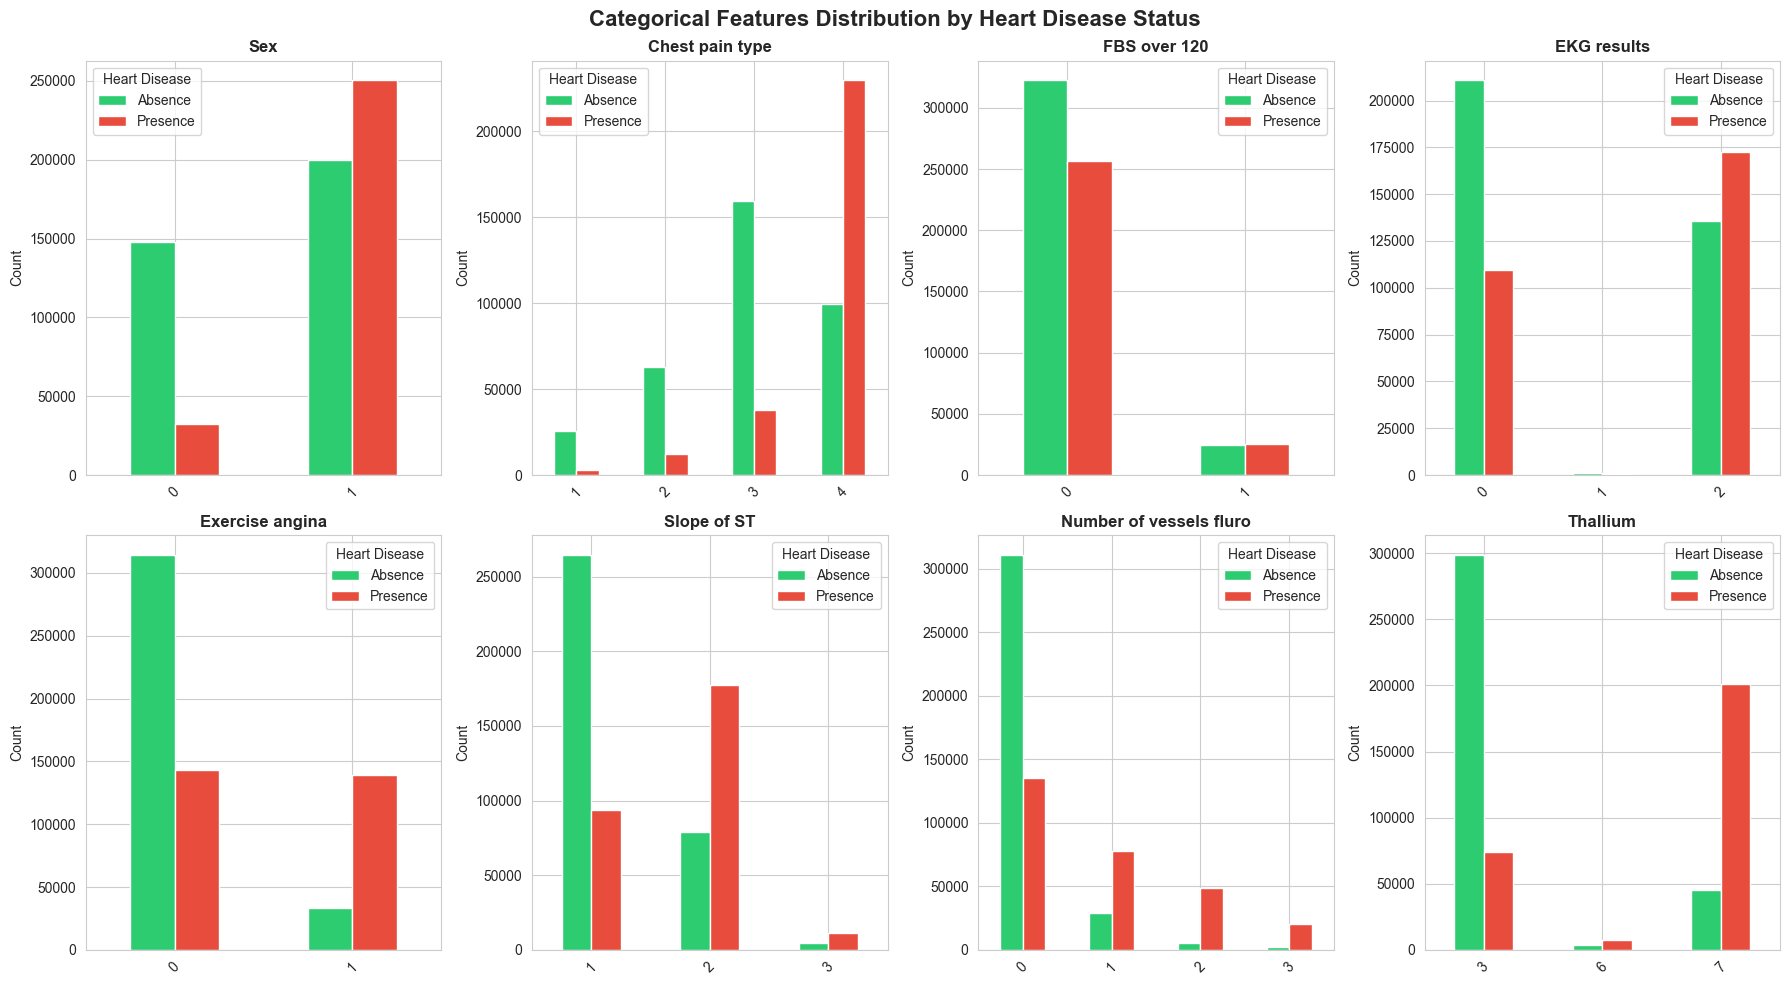


✓ Categorical Features Analysis:

   Sex:
Heart Disease  Absence  Presence     All
Sex                                     
0               147590     32127  179717
1               199956    250327  450283
All             347546    282454  630000

   Chest pain type:
Heart Disease    Absence  Presence     All
Chest pain type                           
1                  25511      3091   28602
2                  62787     12154   74941
3                 159664     37614  197278
4                  99584    229595  329179
All               347546    282454  630000

   FBS over 120:
Heart Disease  Absence  Presence     All
FBS over 120                            
0               322600    257008  579608
1                24946     25446   50392
All             347546    282454  630000

   EKG results:
Heart Disease  Absence  Presence     All
EKG results                             
0               210797    109319  320116
1                  846       476    1322
2               135903    

In [10]:
# Categorical features analysis
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('Categorical Features Distribution by Heart Disease Status', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, col in enumerate(catcols):
    cross_tab = pd.crosstab(train_df[col], train_df[target])
    cross_tab.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(col, fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xlabel('')
    axes[idx].legend(title=target, labels=['Absence', 'Presence'])
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Categorical Features Analysis:")
for col in catcols:
    print(f"\n   {col}:")
    cross_tab = pd.crosstab(train_df[col], train_df[target], margins=True, normalize=False)
    print(cross_tab)

## Step 5: Categorical & Correlation Analysis

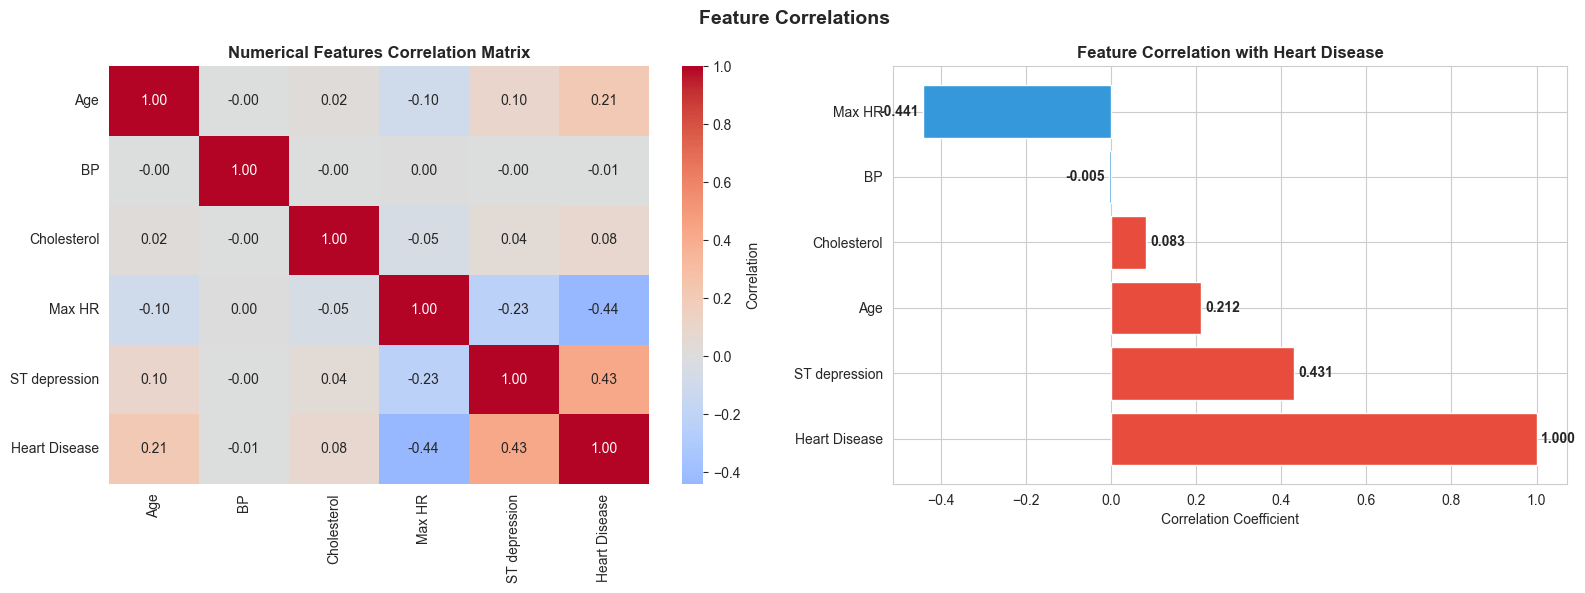


✓ Feature-Target Correlation:
               Heart Disease
Heart Disease         1.0000
ST depression         0.4306
Age                   0.2121
Cholesterol           0.0828
BP                   -0.0052
Max HR               -0.4410


In [11]:
# Correlation analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Correlations', fontsize=14, fontweight='bold')

# Numerical features correlation
numerical_data = train_df[numcols + [target]].copy()
numerical_data[target] = numerical_data[target].map({'Absence': 0, 'Presence': 1})
corr_matrix = numerical_data.corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Numerical Features Correlation Matrix', fontweight='bold')

# Target correlation
target_corr = corr_matrix[[target]].sort_values(target, ascending=False)
axes[1].barh(target_corr.index, target_corr[target].values, color=['#e74c3c' if x > 0 else '#3498db' for x in target_corr[target].values])
axes[1].set_title('Feature Correlation with Heart Disease', fontweight='bold')
axes[1].set_xlabel('Correlation Coefficient')
for i, v in enumerate(target_corr[target].values):
    axes[1].text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}', va='center', ha='left' if v > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Feature-Target Correlation:")
print(target_corr.round(4))

## Step 6: EDA - Distribution & Statistical Analysis


EXPLORATORY DATA ANALYSIS (EDA)


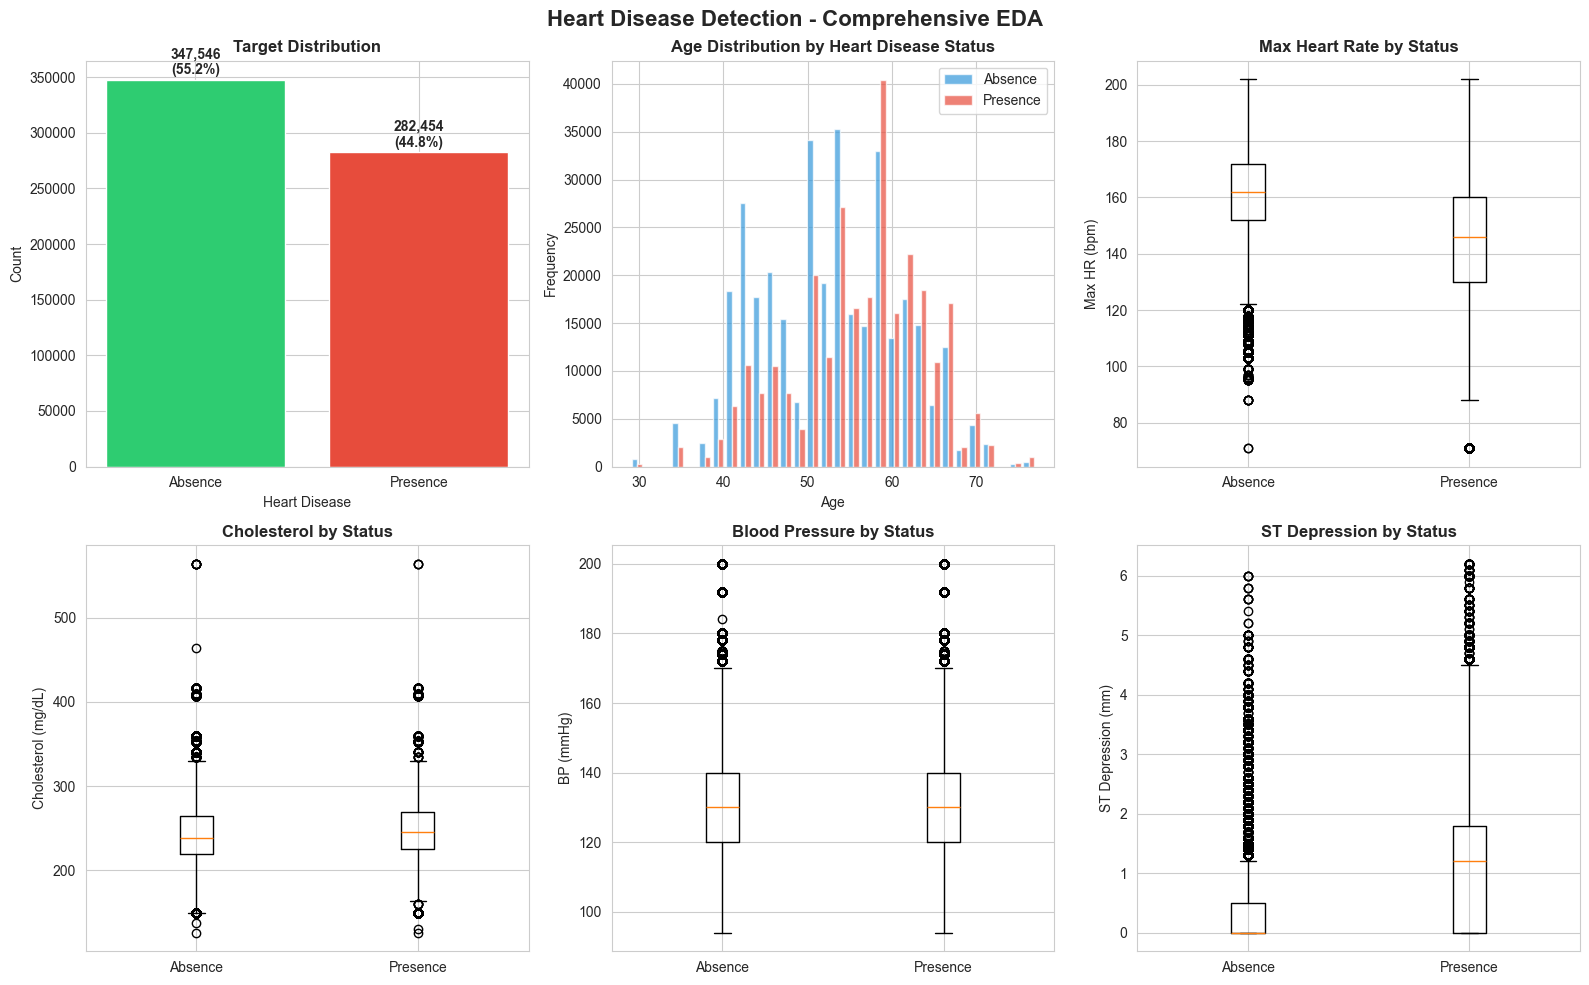


✓ Numerical Features Analysis:
   Age:
      Absence:  52.56
      Presence: 56.08
      Diff: 3.52
   BP:
      Absence:  130.57
      Presence: 130.41
      Diff: 0.16
   Cholesterol:
      Absence:  242.50
      Presence: 248.10
      Diff: 5.60
   Max HR:
      Absence:  160.42
      Presence: 143.47
      Diff: 16.95
   ST depression:
      Absence:  0.35
      Presence: 1.17
      Diff: 0.82


In [ ]:
print("EXPLORATORY DATA ANALYSIS (EDA)")

# 1. Target Distribution
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Heart Disease Detection - Comprehensive EDA', fontsize=16, fontweight='bold')

# Target distribution
target_data = train_df[target].value_counts()
axes[0, 0].bar(target_data.index, target_data.values, color=['#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Target Distribution', fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xlabel(target)
for i, v in enumerate(target_data.values):
    pct = (v / len(train_df)) * 100
    axes[0, 0].text(i, v + 5000, f'{v:,}\n({pct:.1f}%)', ha='center', fontweight='bold')

# 2. Age distribution by target
axes[0, 1].hist([train_df[train_df[target]=='Absence']['Age'], 
                  train_df[train_df[target]=='Presence']['Age']], 
                label=['Absence', 'Presence'], bins=30, alpha=0.7, color=['#3498db', '#e74c3c'])
axes[0, 1].set_title('Age Distribution by Heart Disease Status', fontweight='bold')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Max HR by target
axes[0, 2].boxplot([train_df[train_df[target]=='Absence']['Max HR'], 
                     train_df[train_df[target]=='Presence']['Max HR']], 
                    labels=['Absence', 'Presence'])
axes[0, 2].set_title('Max Heart Rate by Status', fontweight='bold')
axes[0, 2].set_ylabel('Max HR (bpm)')

# 4. Cholesterol by target
axes[1, 0].boxplot([train_df[train_df[target]=='Absence']['Cholesterol'], 
                     train_df[train_df[target]=='Presence']['Cholesterol']], 
                    labels=['Absence', 'Presence'])
axes[1, 0].set_title('Cholesterol by Status', fontweight='bold')
axes[1, 0].set_ylabel('Cholesterol (mg/dL)')

# 5. Blood Pressure by target
axes[1, 1].boxplot([train_df[train_df[target]=='Absence']['BP'], 
                     train_df[train_df[target]=='Presence']['BP']], 
                    labels=['Absence', 'Presence'])
axes[1, 1].set_title('Blood Pressure by Status', fontweight='bold')
axes[1, 1].set_ylabel('BP (mmHg)')

# 6. ST depression by target
axes[1, 2].boxplot([train_df[train_df[target]=='Absence']['ST depression'], 
                     train_df[train_df[target]=='Presence']['ST depression']], 
                    labels=['Absence', 'Presence'])
axes[1, 2].set_title('ST Depression by Status', fontweight='bold')
axes[1, 2].set_ylabel('ST Depression (mm)')

plt.tight_layout()
plt.show()

print("\n✓ Numerical Features Analysis:")
for col in numcols:
    absence_mean = train_df[train_df[target]=='Absence'][col].mean()
    presence_mean = train_df[train_df[target]=='Presence'][col].mean()
    print(f"   {col}:")
    print(f"      Absence:  {absence_mean:.2f}")
    print(f"      Presence: {presence_mean:.2f}")
    print(f"      Diff: {abs(presence_mean - absence_mean):.2f}")

## Step 7: Cross-Validation Setup

In [13]:
N_SPLITS = 5
RANDOM_STATE = 42

# Force CPU-safe configs
tree_method = "hist"
lgbm_device = "cpu"
cat_task = "CPU"

cat_features = [X.columns.get_loc(c) for c in catcols]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [15]:
folds = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

oof = {
    "xgb": np.zeros(len(X)),
    "lgbm": np.zeros(len(X)),
    "cat": np.zeros(len(X)),
    "hist": np.zeros(len(X)),
    "ridge": np.zeros(len(X)),
}

test_preds = {
    "xgb": np.zeros(len(X_test)),
    "lgbm": np.zeros(len(X_test)),
    "cat": np.zeros(len(X_test)),
    "hist": np.zeros(len(X_test)),
    "ridge": np.zeros(len(X_test)),
}

cv_results = []

## Step 8: Model Training with Optuna Optimization (XGBoost, LightGBM, CatBoost)

In [ ]:
print("\n" + "=" * 80)
print("TRAINING WITH OPTUNA OPTIMIZATION & ENSEMBLE CV LOOP")
print("=" * 80)

start_time = time.time()

# OPTUNA OPTIMIZATION FOR XGBOOST 
def objective_xgb(trial, X_train, y_train, X_val, y_val):
    """Optuna objective function for XGBoost hyperparameter optimization"""
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "verbose": 0,
    }
    
    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    val_pred = xgb_model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_pred)
    
    return auc

for fold, (trn_idx, val_idx) in enumerate(folds.split(X, y), 1):
    fold_start = time.time()
    print(f"▶ FOLD {fold}/{N_SPLITS}")

    X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]

    # SCALE ONLY NUMERICAL COLS (for linear model) 
    scaler = StandardScaler()

    X_tr_scaled = X_tr.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    X_tr_scaled[numcols] = scaler.fit_transform(X_tr[numcols])
    X_val_scaled[numcols] = scaler.transform(X_val[numcols])
    X_test_scaled[numcols] = scaler.transform(X_test[numcols])

    # OPTUNA XGBOOST TUNING 
    print(f"\n  Running Optuna hyperparameter optimization for XGBoost...")
    
    study = optuna.create_study(
        direction="maximize",
        pruner=MedianPruner(n_warmup_steps=5)
    )
    study.optimize(
        lambda trial: objective_xgb(trial, X_tr, y_tr, X_val, y_val),
        n_trials=20,
        show_progress_bar=False,
    )
    
    best_xgb_params = study.best_params
    best_xgb_params.update({
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
    })
    
    print(f"  ✓ Best XGBoost AUC (trial): {study.best_value:.4f}")
    print(f"  ✓ Best params: {best_xgb_params}")

    # XGBOOST WITH OPTIMIZED PARAMS 
    xgb = XGBClassifier(**best_xgb_params)
    xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

    xgb_auc = roc_auc_score(y_val, xgb.predict_proba(X_val)[:, 1])
    oof["xgb"][val_idx] = xgb.predict_proba(X_val)[:, 1]
    test_preds["xgb"] += xgb.predict_proba(X_test)[:, 1] / N_SPLITS

    # LIGHTGBM (STRONGEST TREE MODEL) 
    lgbm_params = {
        "n_estimators": 500,
        "learning_rate": 0.05,
        "num_leaves": 31,
        "max_depth": -1,
        "min_child_samples": 100,
        "subsample": 0.8,
        "subsample_freq": 1,
        "colsample_bytree": 0.8,
        "reg_alpha": 0.0,
        "reg_lambda": 1.0,
        "objective": "binary",
        "metric": "auc",
        "random_state": 42,
        "n_jobs": -1,
        "verbose": -1,
    }
    
    lgbm = LGBMClassifier(**lgbm_params)
    lgbm.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="auc")

    lgbm_auc = roc_auc_score(y_val, lgbm.predict_proba(X_val)[:, 1])
    oof["lgbm"][val_idx] = lgbm.predict_proba(X_val)[:, 1]
    test_preds["lgbm"] += lgbm.predict_proba(X_test)[:, 1] / N_SPLITS

    # CATBOOST (MAIN MODEL) 
    cat_params = {
        "iterations": 500,
        "learning_rate": 0.05,
        "depth": 6,
        "l2_leaf_reg": 3.0,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "bootstrap_type": "Bernoulli",
        "subsample": 0.8,
        "random_seed": 42,
        "verbose": False,
        "task_type": "CPU",
    }
    
    cat = CatBoostClassifier(**cat_params)
    cat.fit(
        X_tr,
        y_tr,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=False,
    )

    cat_auc = roc_auc_score(y_val, cat.predict_proba(X_val)[:, 1])
    oof["cat"][val_idx] = cat.predict_proba(X_val)[:, 1]
    test_preds["cat"] += cat.predict_proba(X_test)[:, 1] / N_SPLITS

    # ENSEMBLE (CatBoost → Main, LightGBM → Support, XGBoost → Diversity) 
    ensemble_val = (
        0.5 * oof["cat"][val_idx]  # Main model (CatBoost)
        + 0.3 * oof["lgbm"][val_idx]  # Support model (LightGBM)
        + 0.2 * oof["xgb"][val_idx]  # Diversity (XGBoost)
    )
    
    ensemble_auc = roc_auc_score(y_val, ensemble_val)

    fold_result = {
        "fold": fold,
        "xgb_auc": xgb_auc,
        "lgbm_auc": lgbm_auc,
        "cat_auc": cat_auc,
        "ensemble_auc": ensemble_auc,
    }

    cv_results.append(fold_result)

    print(f"\n  Model Scores:")
    print(f"      XGBoost:  {xgb_auc:.4f}")
    print(f"      LightGBM: {lgbm_auc:.4f}")
    print(f"      CatBoost: {cat_auc:.4f}")
    print(f"      Ensemble: {ensemble_auc:.4f}")

    print(f"\n  ⏱ Fold time: {time.time() - fold_start:.1f}s")

print(f"TOTAL TRAINING TIME: {(time.time() - start_time):.1f}s")


TRAINING WITH OPTUNA OPTIMIZATION & ENSEMBLE CV LOOP

▶ FOLD 1/5


[I 2026-02-01 18:07:37,539] A new study created in memory with name: no-name-07b6c342-42bd-40d5-8723-119987161025



  🔍 Running Optuna hyperparameter optimization for XGBoost...


[I 2026-02-01 18:07:49,508] Trial 0 finished with value: 0.9555459428979539 and parameters: {'n_estimators': 377, 'learning_rate': 0.09361262165841651, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.5983996352136265, 'colsample_bytree': 0.8871997451948683, 'gamma': 4.801404735861538, 'reg_alpha': 0.815577483643234, 'reg_lambda': 0.6267757442068064}. Best is trial 0 with value: 0.9555459428979539.
[I 2026-02-01 18:08:11,956] Trial 1 finished with value: 0.9555340591795207 and parameters: {'n_estimators': 351, 'learning_rate': 0.06873839716974435, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7579722962306323, 'colsample_bytree': 0.9669421769686697, 'gamma': 0.5820554189128385, 'reg_alpha': 0.6598711244597458, 'reg_lambda': 1.4116303724579757}. Best is trial 0 with value: 0.9555459428979539.
[I 2026-02-01 18:08:25,951] Trial 2 finished with value: 0.9551762546612521 and parameters: {'n_estimators': 171, 'learning_rate': 0.06025028847974225, 'max_depth': 8, 'min_child_weigh

  ✓ Best XGBoost AUC (trial): 0.9557
  ✓ Best params: {'n_estimators': 301, 'learning_rate': 0.08525520852422949, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6978938316752329, 'colsample_bytree': 0.5857514543944273, 'gamma': 1.5991961600645213, 'reg_alpha': 0.21365009536939916, 'reg_lambda': 1.0413756849806297, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}

  📊 Model Scores:
      XGBoost:  0.9557
      LightGBM: 0.9556
      CatBoost: 0.9556
      Ensemble: 0.9557

  ⏱ Fold time: 739.9s

▶ FOLD 2/5


[I 2026-02-01 18:19:57,363] A new study created in memory with name: no-name-3c63e3f1-0a9e-46ab-9449-0b96cd6af7d0



  🔍 Running Optuna hyperparameter optimization for XGBoost...


[I 2026-02-01 18:20:11,899] Trial 0 finished with value: 0.9546643750072428 and parameters: {'n_estimators': 479, 'learning_rate': 0.07091211253125744, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8276487759348753, 'colsample_bytree': 0.8744946094320258, 'gamma': 1.8983062610645836, 'reg_alpha': 0.026345353298120378, 'reg_lambda': 1.708907274570425}. Best is trial 0 with value: 0.9546643750072428.
[I 2026-02-01 18:20:25,032] Trial 1 finished with value: 0.9545952851519911 and parameters: {'n_estimators': 354, 'learning_rate': 0.044011458142540455, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.7577385551447449, 'colsample_bytree': 0.6100366618724986, 'gamma': 0.07277774136051185, 'reg_alpha': 0.3167293912406487, 'reg_lambda': 1.9444574443915612}. Best is trial 0 with value: 0.9546643750072428.
[I 2026-02-01 18:20:32,558] Trial 2 finished with value: 0.9546688084494205 and parameters: {'n_estimators': 222, 'learning_rate': 0.09391135777775741, 'max_depth': 5, 'min_child_

  ✓ Best XGBoost AUC (trial): 0.9547
  ✓ Best params: {'n_estimators': 222, 'learning_rate': 0.09391135777775741, 'max_depth': 5, 'min_child_weight': 20, 'subsample': 0.6130105866596025, 'colsample_bytree': 0.6123190352532291, 'gamma': 2.1767877123245514, 'reg_alpha': 0.9791899902336729, 'reg_lambda': 0.8679320047096556, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}

  📊 Model Scores:
      XGBoost:  0.9547
      LightGBM: 0.9546
      CatBoost: 0.9545
      Ensemble: 0.9547

  ⏱ Fold time: 795.5s

▶ FOLD 3/5


[I 2026-02-01 18:33:13,015] A new study created in memory with name: no-name-b80598dd-c74c-442c-a491-af049cbfa0d5



  🔍 Running Optuna hyperparameter optimization for XGBoost...


[I 2026-02-01 18:33:42,486] Trial 0 finished with value: 0.9551242950041596 and parameters: {'n_estimators': 455, 'learning_rate': 0.04040150600974845, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.5390020719017229, 'colsample_bytree': 0.8969141029689478, 'gamma': 2.1682031626198848, 'reg_alpha': 0.5258099068159565, 'reg_lambda': 1.644857955538986}. Best is trial 0 with value: 0.9551242950041596.
[I 2026-02-01 18:34:08,925] Trial 1 finished with value: 0.9553912486567224 and parameters: {'n_estimators': 455, 'learning_rate': 0.07838301853117442, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.9480646359843742, 'colsample_bytree': 0.8325387328508271, 'gamma': 0.6031299955201169, 'reg_alpha': 0.8610598293496783, 'reg_lambda': 1.4091598591635814}. Best is trial 1 with value: 0.9553912486567224.
[I 2026-02-01 18:34:37,758] Trial 2 finished with value: 0.9553262124016743 and parameters: {'n_estimators': 478, 'learning_rate': 0.06221421408580579, 'max_depth': 4, 'min_child_weig

  ✓ Best XGBoost AUC (trial): 0.9554
  ✓ Best params: {'n_estimators': 432, 'learning_rate': 0.09073278866825035, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8868158559265612, 'colsample_bytree': 0.7854486791564442, 'gamma': 1.4384277681709807, 'reg_alpha': 0.7408049870881487, 'reg_lambda': 1.79120603432907, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}

  📊 Model Scores:
      XGBoost:  0.9554
      LightGBM: 0.9554
      CatBoost: 0.9553
      Ensemble: 0.9555

  ⏱ Fold time: 622.9s

▶ FOLD 4/5


[I 2026-02-01 18:43:35,819] A new study created in memory with name: no-name-83be3a33-e227-47e3-b8d5-22250812a702



  🔍 Running Optuna hyperparameter optimization for XGBoost...


[I 2026-02-01 18:43:44,135] Trial 0 finished with value: 0.9547304265087071 and parameters: {'n_estimators': 292, 'learning_rate': 0.08985672956107384, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 0.5871365517421382, 'colsample_bytree': 0.8842185836871945, 'gamma': 2.2480077180579454, 'reg_alpha': 0.4952451096035594, 'reg_lambda': 0.6855137157850955}. Best is trial 0 with value: 0.9547304265087071.
[I 2026-02-01 18:44:00,302] Trial 1 finished with value: 0.9543365287260763 and parameters: {'n_estimators': 432, 'learning_rate': 0.09293468233424593, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.9080917486944704, 'colsample_bytree': 0.6752261833854627, 'gamma': 0.11978144170159966, 'reg_alpha': 0.4751325098359396, 'reg_lambda': 0.8509426661685187}. Best is trial 0 with value: 0.9547304265087071.
[I 2026-02-01 18:44:09,481] Trial 2 finished with value: 0.9549059505554458 and parameters: {'n_estimators': 270, 'learning_rate': 0.08755133087899708, 'max_depth': 6, 'min_child_

  ✓ Best XGBoost AUC (trial): 0.9550
  ✓ Best params: {'n_estimators': 358, 'learning_rate': 0.07518530927744169, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.506081577623228, 'colsample_bytree': 0.5952984196480534, 'gamma': 2.818734602062964, 'reg_alpha': 0.6364955951469851, 'reg_lambda': 1.4845186619232036, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}

  📊 Model Scores:
      XGBoost:  0.9550
      LightGBM: 0.9550
      CatBoost: 0.9548
      Ensemble: 0.9550

  ⏱ Fold time: 773.1s

▶ FOLD 5/5


[I 2026-02-01 18:56:28,822] A new study created in memory with name: no-name-267b6bb7-4974-435b-90a3-53e417f10584



  🔍 Running Optuna hyperparameter optimization for XGBoost...


[I 2026-02-01 18:56:40,265] Trial 0 finished with value: 0.9532609724969814 and parameters: {'n_estimators': 407, 'learning_rate': 0.010533184488621145, 'max_depth': 4, 'min_child_weight': 12, 'subsample': 0.9281886788431559, 'colsample_bytree': 0.9984248341897646, 'gamma': 2.769125360577407, 'reg_alpha': 0.43612602502627495, 'reg_lambda': 1.6422781706725615}. Best is trial 0 with value: 0.9532609724969814.
[I 2026-02-01 18:56:48,892] Trial 1 finished with value: 0.9545235817197382 and parameters: {'n_estimators': 204, 'learning_rate': 0.025403448305109946, 'max_depth': 8, 'min_child_weight': 18, 'subsample': 0.8595702371587286, 'colsample_bytree': 0.9455139414971776, 'gamma': 4.6654644986620895, 'reg_alpha': 0.8896865804026741, 'reg_lambda': 1.6149550985725547}. Best is trial 1 with value: 0.9545235817197382.
[I 2026-02-01 18:57:00,570] Trial 2 finished with value: 0.9547522883485615 and parameters: {'n_estimators': 387, 'learning_rate': 0.02375299198657273, 'max_depth': 4, 'min_child

  ✓ Best XGBoost AUC (trial): 0.9559
  ✓ Best params: {'n_estimators': 492, 'learning_rate': 0.09709265929962282, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.9986761998919607, 'colsample_bytree': 0.5219269429807637, 'gamma': 0.06952175006585382, 'reg_alpha': 0.03706008963739048, 'reg_lambda': 0.5499038209442726, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}

  📊 Model Scores:
      XGBoost:  0.9559
      LightGBM: 0.9558
      CatBoost: 0.9557
      Ensemble: 0.9559

  ⏱ Fold time: 814.3s

TOTAL TRAINING TIME: 3745.8s


## Step 9: Cross-Validation Results & Ensemble Performance


CROSS-VALIDATION RESULTS SUMMARY
   fold   xgb_auc  lgbm_auc   cat_auc  ensemble_auc
0     1  0.955724  0.955628  0.955555      0.955712
1     2  0.954669  0.954617  0.954527      0.954681
2     3  0.955435  0.955417  0.955279      0.955471
3     4  0.955032  0.955017  0.954846      0.955033
4     5  0.955895  0.955824  0.955673      0.955918

📈 Mean Scores:
  XGBoost:  0.9554 ± 0.0005
  LightGBM: 0.9553 ± 0.0005
  CatBoost: 0.9552 ± 0.0005
  Ensemble: 0.9554 ± 0.0005


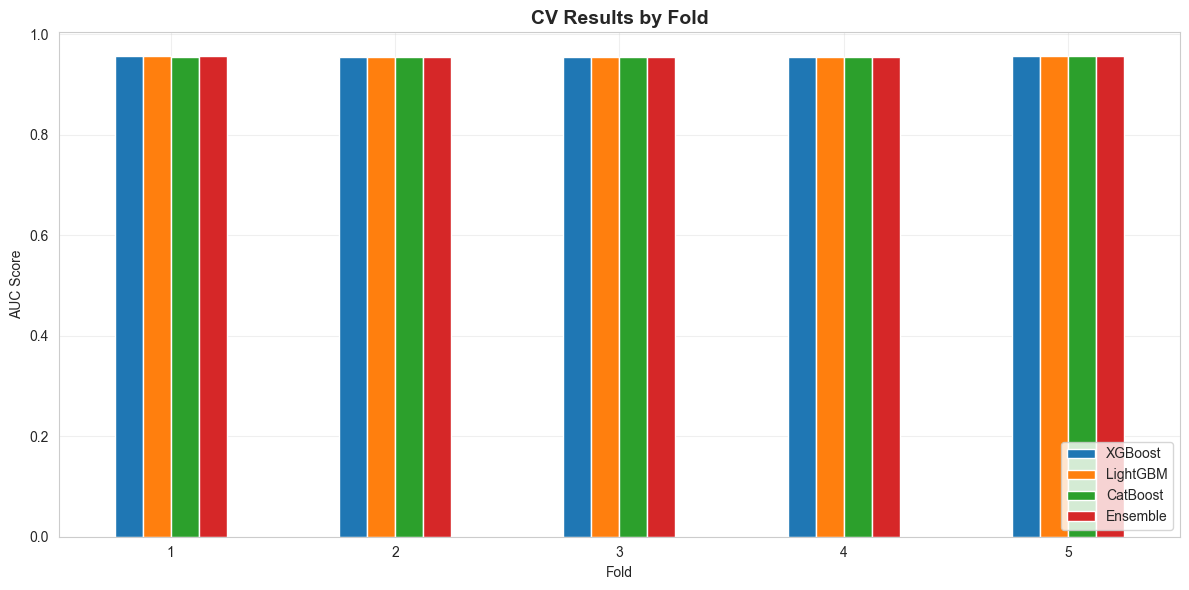

In [ ]:
# CROSS-VALIDATION RESULTS 
cv_df = pd.DataFrame(cv_results)
print("\n" + "=" * 80)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("=" * 80)
print(cv_df)

print("\nMean Scores:")
print(f"  XGBoost:  {cv_df['xgb_auc'].mean():.4f} ± {cv_df['xgb_auc'].std():.4f}")
print(f"  LightGBM: {cv_df['lgbm_auc'].mean():.4f} ± {cv_df['lgbm_auc'].std():.4f}")
print(f"  CatBoost: {cv_df['cat_auc'].mean():.4f} ± {cv_df['cat_auc'].std():.4f}")
print(f"  Ensemble: {cv_df['ensemble_auc'].mean():.4f} ± {cv_df['ensemble_auc'].std():.4f}")

# Plot CV results
fig, ax = plt.subplots(figsize=(12, 6))
cv_df.set_index('fold')[['xgb_auc', 'lgbm_auc', 'cat_auc', 'ensemble_auc']].plot(kind='bar', ax=ax)
ax.set_title('CV Results by Fold', fontsize=14, fontweight='bold')
ax.set_ylabel('AUC Score')
ax.set_xlabel('Fold')
ax.legend(['XGBoost', 'LightGBM', 'CatBoost', 'Ensemble'], loc='lower right')
ax.grid(alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Step 10: Final Submission - Binary Predictions

In [ ]:
# RETRAIN ON FULL DATA & PREDICT ON TEST SET 
print("RETRAINING MODELS ON FULL DATA FOR TEST PREDICTIONS")

# Prepare test data (encode categorical features if needed)
test = test_df.drop(columns=drop_cols)
test_scaled = test.copy()
scaler_full = StandardScaler()
scaler_full.fit(X[numcols])
test_scaled[numcols] = scaler_full.transform(test[numcols])

# Get cat_features for test set
cat_features_test = [test.columns.get_loc(c) for c in catcols if c in test.columns]

# Final test predictions dictionary
final_test_preds = {
    "xgb": np.zeros(len(test)),
    "lgbm": np.zeros(len(test)),
    "cat": np.zeros(len(test)),
}

print(f"\n✓ Kaggle test set shape: {test.shape}")
print(f"✓ Training on full dataset: {X.shape}")

# Train models on FULL training data
print("\n  Retraining models on full training data...")

# RETRAIN XGBOOST
print("  Training XGBoost on full data...")
xgb_final = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.0,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)
xgb_final.fit(X, y, verbose=False)
final_test_preds["xgb"] = xgb_final.predict_proba(test)[:, 1]

# RETRAIN LIGHTGBM
print("  Training LightGBM on full data...")
lgbm_final = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=100,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective="binary",
    metric="auc",
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)
lgbm_final.fit(X, y)
final_test_preds["lgbm"] = lgbm_final.predict_proba(test)[:, 1]

# RETRAIN CATBOOST
print("  Training CatBoost on full data...")
cat_final = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    loss_function="Logloss",
    eval_metric="AUC",
    bootstrap_type="Bernoulli",
    subsample=0.8,
    random_seed=42,
    verbose=False,
    task_type="CPU",
)
cat_final.fit(X, y, cat_features=cat_features, verbose=False)
final_test_preds["cat"] = cat_final.predict_proba(test)[:, 1]

print("\n✓ All models trained successfully!")

# CREATE FINAL SUBMISSION 
print("GENERATING FINAL SUBMISSION")

# Create ensemble predictions on test set
test_ensemble_preds = (
    0.5 * final_test_preds["cat"]  # Main model (CatBoost)
    + 0.3 * final_test_preds["lgbm"]  # Support model (LightGBM)
    + 0.2 * final_test_preds["xgb"]  # Diversity (XGBoost)
)

# Create submission with PROBABILITY predictions
submission = pd.DataFrame({
    'id': test_df['id'],
    'Heart Disease': test_ensemble_preds
})

submission.to_csv('submission.csv', index=False)

print(f"\n✓ Submission saved: submission.csv")
print(f"\nFirst 10 predictions:")
print(submission.head(10))
print(f"\nPrediction statistics:")
print(f"  Mean: {test_ensemble_preds.mean():.4f}")
print(f"  Std:  {test_ensemble_preds.std():.4f}")
print(f"  Min:  {test_ensemble_preds.min():.4f}")
print(f"  Max:  {test_ensemble_preds.max():.4f}")
print(f"\n✓ Total samples in submission: {len(submission)}")


GENERATING FINAL SUBMISSION

✓ Submission saved: submission_optuna_ensemble.csv

First 10 predictions (BINARY):
       id  Heart Disease
0  630000              1
1  630001              0
2  630002              1
3  630003              0
4  630004              0
5  630005              1
6  630006              0
7  630007              1
8  630008              1
9  630009              0

Prediction distribution:
  Class 0 (No disease): 150,612 samples
  Class 1 (Disease):    119,388 samples
  Ratio: 44.22% positive

✓ Total samples in submission: 270000

✓ Probability predictions saved: submission_optuna_ensemble_probabilities.csv



OUT-OF-FOLD (OOF) VALIDATION SCORES
  XGBoost      OOF AUC: 0.9554
  LightGBM     OOF AUC: 0.9553
  CatBoost     OOF AUC: 0.9552
  Ensemble     OOF AUC: 0.9554


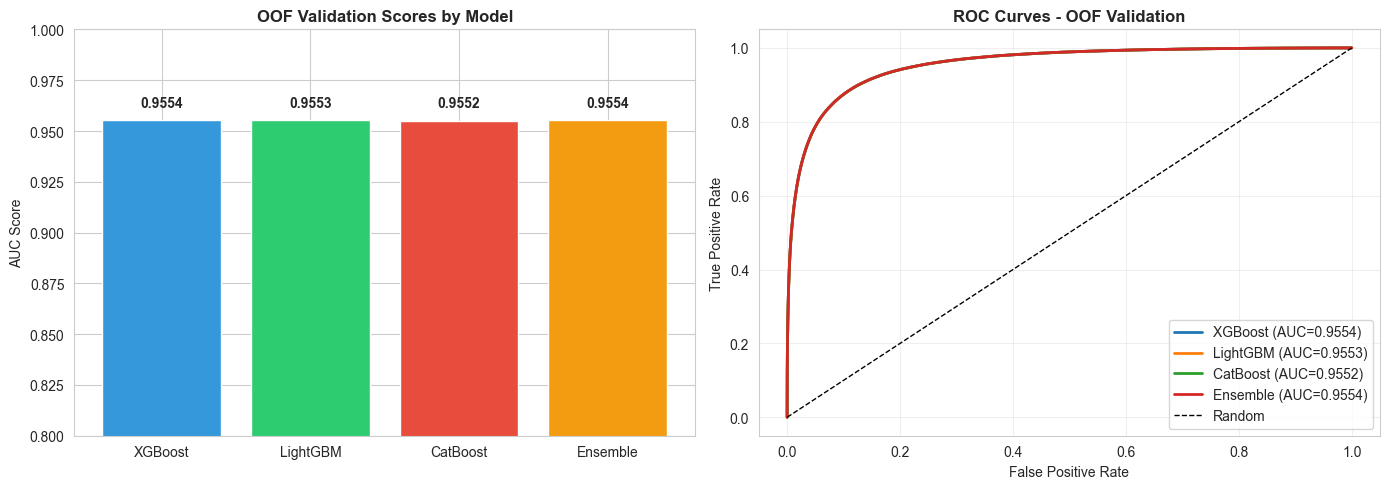


✓ Model pipeline complete!


In [ ]:
# OOF VALIDATION SCORES
print("\n" + "=" * 80)
print("OUT-OF-FOLD (OOF) VALIDATION SCORES")
print("=" * 80)

# Create ensemble OOF predictions
oof_ensemble = (
    0.5 * oof["cat"]  # Main model (CatBoost)
    + 0.3 * oof["lgbm"]  # Support model (LightGBM)
    + 0.2 * oof["xgb"]  # Diversity (XGBoost)
)

oof_scores = {
    "XGBoost": roc_auc_score(y, oof["xgb"]),
    "LightGBM": roc_auc_score(y, oof["lgbm"]),
    "CatBoost": roc_auc_score(y, oof["cat"]),
    "Ensemble": roc_auc_score(y, oof_ensemble),
}

for model_name, score in oof_scores.items():
    print(f"  {model_name:12} OOF AUC: {score:.4f}")

# Plot OOF scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
models = list(oof_scores.keys())
scores = list(oof_scores.values())
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
axes[0].bar(models, scores, color=colors)
axes[0].set_title('OOF Validation Scores by Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('AUC Score')
axes[0].set_ylim([0.8, 1.0])
for i, v in enumerate(scores):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# ROC curves
from sklearn.metrics import roc_curve

for model_name, oof_pred in [("XGBoost", oof["xgb"]), 
                              ("LightGBM", oof["lgbm"]), 
                              ("CatBoost", oof["cat"]),
                              ("Ensemble", oof_ensemble)]:
    fpr, tpr, _ = roc_curve(y, oof_pred)
    auc = oof_scores[model_name]
    axes[1].plot(fpr, tpr, label=f"{model_name} (AUC={auc:.4f})", linewidth=2)

axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves - OOF Validation', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Model pipeline complete!")

## Step 11: Out-of-Fold Validation & ROC Analysis